In [1]:
# Baixar arquivos adicionais para o laboratório
!wget https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
      
!unzip -n -q lab_utils_ml_adv_week_1.zip

--2024-03-10 12:26:30--  https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip [following]
--2024-03-10 12:26:31--  https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/nn_adv/class_01/Laborat%C3%B3rios/lab_utils_ml_adv_week_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1984766 (1.9M) [application/zip]
Saving to: ‘l

In [2]:
# Testar se estamos no Google Colab
try:
  import google.colab
  IN_COLAB = True
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  IN_COLAB = False

# Rede Neural Simples com Tensorflow
Neste laboratório, criaremos uma pequena rede neural usando o Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


2024-03-10 12:26:32.133414: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 12:26:32.158870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 12:26:32.158896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 12:26:32.158912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 12:26:32.164208: I tensorflow/core/platform/cpu_feature_g

## Conjunto de Dados

In [4]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Vamos plotar os dados de torrefação de café abaixo. Os dois recursos são Temperatura em Celsius e Duração em minutos. A [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) sugere que a duração deve ser mantida entre 12 e 15 minutos, enquanto a temperatura deve estar entre 175 e 260 graus Celsius. É claro que, com o aumento da temperatura, a duração deve diminuir.

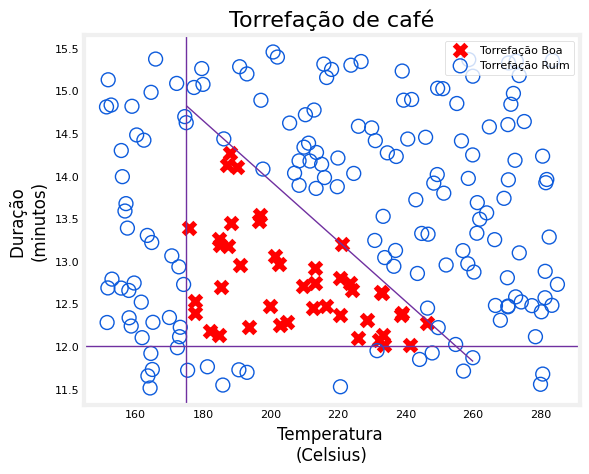

In [5]:
plt_roast(X,Y)

### Normalizar os Dados
O ajuste dos pesos aos dados (retropropagação, que será abordado em aulas mais a frente) ocorrerá mais rapidamente se os dados forem normalizados. 
O procedimento abaixo usa uma [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/) do Keras. Ele tem as seguintes etapas:
- criar uma "Camada de normalização". Observe que, conforme aplicado aqui, essa não é uma camada em seu modelo.
- "adaptar" os dados: aprender a média e a variância do conjunto de dados e salvar os valores internamente.
- normalizar os dados.  
É importante aplicar a normalização a todos os dados futuros que utilizem o modelo aprendido.

In [6]:
print(f"Temperatura máxima e mínima antes da normalização: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duração máxima e mínima antes da normalização: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # aprender média e variância
Xn = norm_l(X)
print(f"Temperatura máxima e mínima após a normalização: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duração máxima e mínima após a normalização: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperatura máxima e mínima antes da normalização: 284.99, 151.32
Duração máxima e mínima antes da normalização: 15.45, 11.51


2024-03-10 12:26:33.494726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 12:26:33.498111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 12:26:33.498228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Temperatura máxima e mínima após a normalização: 1.66, -1.69
Duração máxima e mínima após a normalização: 1.79, -1.70


Colocar em mosaico/copiar nossos dados para aumentar o tamanho do conjunto de treinamento e reduzir o número de épocas de treinamento.

In [7]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


## Modelo Tensorflow

### Modelo
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Vamos criar a "Rede de torrefação de café" descrita na aula. Há duas camadas com ativações sigmoides, conforme mostrado abaixo:

In [8]:
tf.random.set_seed(1234)# aplicado para obter resultados consistentes
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

>**Nota 1:** O `tf.keras.Input(shape=(2,)),` especifica a forma esperada da entrada. Isso permite que o Tensorflow dimensione os pesos e os parâmetros de polarização nesse ponto.  Isso é útil ao explorar os modelos do Tensorflow. Na prática, essa instrução pode ser omitida e o Tensorflow dimensionará os parâmetros da rede quando os dados de entrada forem especificados na instrução `model.fit`.  
>**Nota 2:** A inclusão da ativação sigmoide na camada final não é considerada uma prática recomendada. Em vez disso, ela seria contabilizada na perda, o que melhora a estabilidade numérica. Isso será descrito em mais detalhes em um laboratório posterior.

O `model.summary()` fornece uma descrição da rede:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As contagens de parâmetros mostradas no resumo correspondem ao número de elementos nas matrizes de peso e bias, conforme mostrado abaixo.

In [10]:
L1_num_params = 2 * 3 + 3   # parâmetros W1 + b1 parâmetros 
L2_num_params = 3 * 1 + 1   # parâmetros W2 + b2 parâmetros 
print("Parâmetros de layer1 = ", L1_num_params, ", Parâmetros de layer2 = ", L2_num_params  )

Parâmetros de layer1 =  9 , Parâmetros de layer2 =  4


Vamos examinar os pesos e as vieses que o Tensorflow instanciou.  Os pesos $W$ devem ser do tamanho (número de recursos na entrada, número de unidades na camada), enquanto o tamanho do viés  $b$ deve corresponder ao número de unidades na camada:
- Na primeira camada com 3 unidades, esperamos que W tenha um tamanho de (2,3) e $b$ deve ter 3 elementos.
- Na segunda camada com 1 unidade, esperamos que W tenha um tamanho de (3,1) e $b$ tenha 1 elemento.

In [11]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-1.09 -1.09  0.44]
 [-0.11  0.86  1.08]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.31]
 [ 0.87]
 [-0.11]] 
b2(1,): [0.]


As declarações a seguir serão descritas em detalhes em aulas mais a frente. Por enquanto:
- A instrução `model.compile` define uma função de perda e especifica uma otimização de compilação.
- O comando `model.fit` executa a descida de gradiente e ajusta os pesos aos dados.

In [12]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10


2024-03-10 12:26:34.852259: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7e3160f9b130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 12:26:34.852281: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-03-10 12:26:34.855081: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 12:26:34.863043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-03-10 12:26:34.914411: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6250/6250 [==============================] - 7s 1ms/step - loss: 0.1813
Epoch 2/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0596
Epoch 3/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0189
Epoch 4/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0114
Epoch 5/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0077
Epoch 6/10
6250/6250 [==============================] - 6s 990us/step - loss: 0.0054
Epoch 7/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0037
Epoch 8/10
6250/6250 [==============================] - 6s 985us/step - loss: 0.0026
Epoch 9/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0018
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0013


#### Épocas(_epochs_) e lotes(_batches_)
Na instrução `fit` acima, o número de `epochs` foi definido como 10. Isso especifica que todo o conjunto de dados deve ser aplicado 10 vezes durante o treinamento.  Durante o treinamento, você verá uma saída descrevendo o progresso do treinamento que se parece com isto:
```
Época 1/10
6250/6250 [==============================] - 6s 910us/passo - perda: 0.1782
```
A primeira linha, `Epoch 1/10`, descreve a época em que o modelo está sendo executado no momento. Para maior eficiência, o conjunto de dados de treinamento é dividido em "lotes". O tamanho padrão de um lote no Tensorflow é 32. Há 200.000 exemplos em nosso conjunto de dados expandido ou 6250 lotes. A notação na segunda linha `6250/6250 [====` está descrevendo qual lote foi executado.

#### Pesos atualizados
Após o ajuste, os pesos foram atualizados:

In [13]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-11.15   0.2   14.85]
 [ -0.31  10.53  12.31]] 
b1: [-11.98  12.69   2.07]
W2:
 [[-57.24]
 [ 47.02]
 [-48.24]] 
b2: [-14.6]


Você pode ver que os valores são diferentes dos que você imprimiu antes de chamar `model.fit()`. Com esses valores, o modelo deve ser capaz de discernir o que é uma torra de café boa ou ruim.

Para fins da próxima discussão, em vez de usar os pesos obtidos imediatamente, você primeiro definirá alguns pesos que salvamos de uma execução de treinamento anterior. Isso é para que esse notebook permaneça robusto às mudanças no Tensorflow ao longo do tempo. Diferentes execuções de treinamento podem produzir resultados um pouco diferentes, e a discussão a seguir se aplica quando o modelo tem os pesos que você carregará abaixo. 

Sinta-se à vontade para executar novamente o notebook mais tarde com a célula abaixo comentada para ver se há alguma diferença. Se você obteve uma perda baixa após o treinamento acima (por exemplo, 0,002), provavelmente obterá os mesmos resultados.

In [14]:
# Depois de terminar o laboratório, você poderá executar novamente todas as células 
# todas as células, exceto esta, para ver se o modelo treinado
# obtém os mesmos resultados.

# Defina os pesos de uma execução anterior.
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])

# Substitua os pesos de seu modelo treinado pelos
# os valores acima.
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [15]:
# Verificar se os pesos foram substituídos com sucesso
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-8.94  0.29 12.89]
 [-0.17 -7.34 10.79]] 
b1: [-9.87 -9.28  1.01]
W2:
 [[-31.38]
 [-27.86]
 [-32.79]] 
b2: [15.54]


### Predições
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Quando você tiver um modelo treinado, poderá usá-lo para fazer previsões. Lembre-se de que o resultado do nosso modelo é uma probabilidade. Nesse caso, a probabilidade de uma boa torra. Para tomar uma decisão, é preciso aplicar a probabilidade a um limiar. Nesse caso, usaremos 0,5

Vamos começar criando dados de entrada. O modelo está esperando um ou mais exemplos, sendo que os exemplos estão nas linhas da matriz. Neste caso, temos dois recursos, portanto, a matriz será (m,2), em que m é o número de exemplos.
Lembre-se de que normalizamos os recursos de entrada, portanto, também devemos normalizar nossos dados de teste.   
Para fazer uma previsão, você aplica o método `predict`.

In [16]:
X_test = np.array([
    [200,13.9],  # exemplo positivo
    [200,17]])   # exemplo negativo
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predições = \n", predictions)

1/1 [==============================] - 0s 38ms/step
predições = 
 [[9.63e-01]
 [3.03e-08]]


Para converter as probabilidades em uma decisão, aplicamos um limite:

In [17]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisões = \n{yhat}")

decisões = 
[[1.]
 [0.]]


Isso pode ser feito de forma mais sucinta:

In [18]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisões = \n{yhat}")

decisões = 
[[1]
 [0]]


## Funções da camada
Vamos examinar as funções das unidades para determinar seu papel na decisão de torrefação do café. Traçaremos a saída de cada nó para todos os valores das entradas (duração, temperatura). Cada unidade é uma função logística cujo resultado pode variar de zero a um. O sombreamento no gráfico representa o valor de saída.
> Observação: nos laboratórios, geralmente numeramos as coisas começando em zero, enquanto as aulas podem começar com 1.

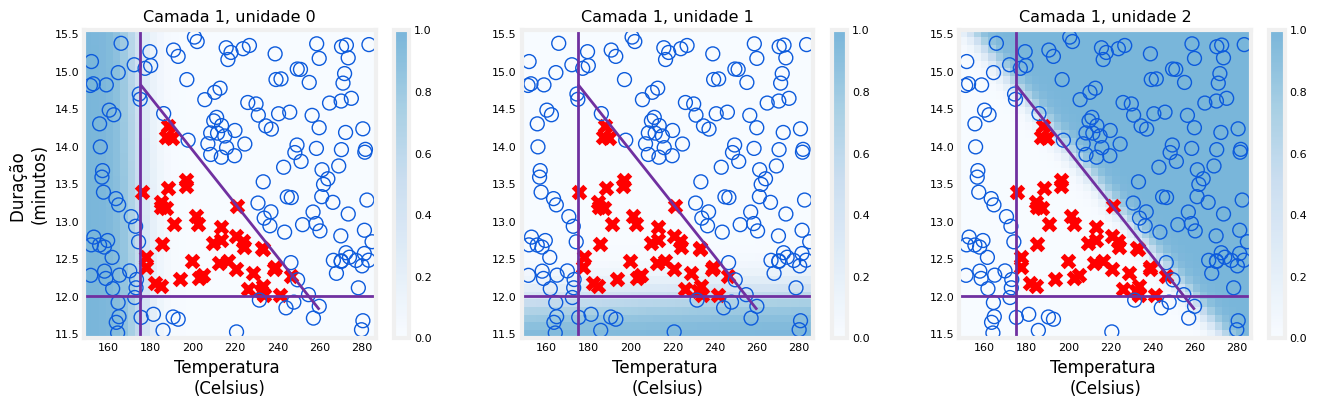

In [19]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

O sombreamento mostra que cada unidade é responsável por uma região diferente de "torrefação ruim". A unidade 0 tem valores maiores quando a temperatura é muito baixa. A unidade 1 tem valores maiores quando a duração é muito curta e a unidade 2 tem valores maiores para combinações ruins de tempo/temperatura. É importante observar que a rede aprendeu essas funções por conta própria por meio do processo de descida de gradiente. Elas são praticamente o mesmo tipo de função que uma pessoa poderia escolher para tomar as mesmas decisões.

O gráfico da função da camada final é um pouco mais difícil de visualizar. Suas entradas são a saída da primeira camada. Sabemos que a primeira camada usa sigmoides, portanto, seu intervalo de saída está entre zero e um. Podemos criar um gráfico 3D que calcula a saída para todas as combinações possíveis das três entradas. Isso é mostrado abaixo. Acima, os valores altos de saída correspondem às áreas de "torrefação ruim". Abaixo, a saída máxima está na área em que as três entradas têm valores pequenos, correspondendo à área de "torrefação boa".

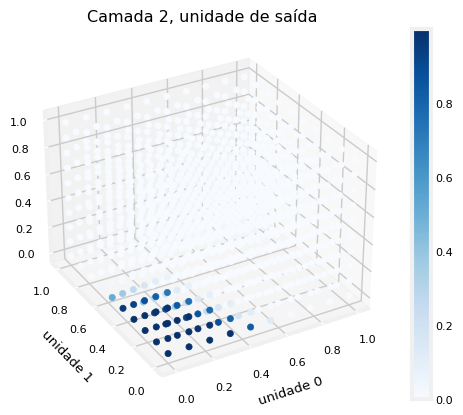

In [20]:
plt_output_unit(W2,b2)

O gráfico final abaixo mostra a rede inteira em ação.  
O gráfico da esquerda é a saída bruta da camada final representada pelo sombreamento azul. Ela é sobreposta aos dados de treinamento representados pelos Xs e Os.   
O gráfico da direita é a saída da rede após um limite de decisão. Os Xs e Os aqui correspondem às decisões tomadas pela rede.  
O gráfico a seguir demora um pouco para ser executado

7/7 [==============================] - 0s 578us/step


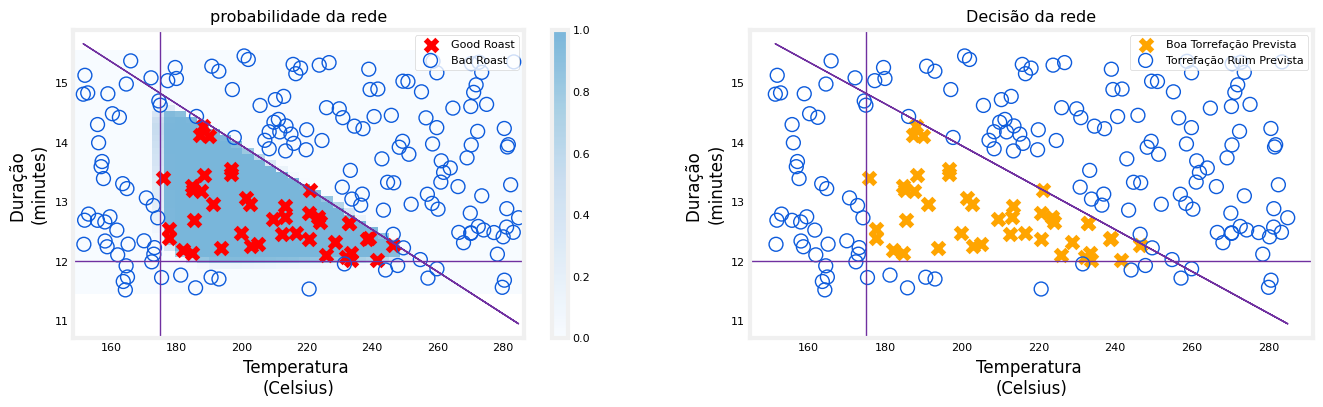

In [21]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

## Parabéns!
Você criou uma pequena rede neural no Tensorflow. 
A rede demonstrou a capacidade das redes neurais de lidar com decisões complexas, dividindo as decisões entre várias unidades.